In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(15000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from model9698 import FixCapsNet
from images_show import ImageShow

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc= 0.
#defined 
try:
    print(len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                )

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((308,308)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"skin_lesion"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 168
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 10]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 7 types.
Using 10 dataloader workers every process.
using 51699 images for training, 828 images for validation.


In [6]:
# Create capsule network.
conv_outputs = 128 #128_Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     num_primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=True,mode="128")

network = network.to(device)
summary(network,(n_channels,img_size,img_size))
# network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 135, 135]         369,024
              ReLU-2        [-1, 128, 135, 135]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(31, 31), stride=(2, 2), bias=False)
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [8]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [9]:
def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())    
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Greens)
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion Matrix.png",dpi=128)

In [10]:
def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [11]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [12]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    print(f'Epoch: [{epoch}] {img_title} ==> Training ...')
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        
        # target = torch.as_tensor(target, dtype=torch.int64)#for windows

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        optimizer.zero_grad()
        output = network(data)

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        
        loss = network.loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f}, ACC:{:.5f}%".format(batch_idx,len(train_loader),
                                                           loss,
                                                           r_pre/(batch_idx*BatchSize),))
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)    
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    
    print(f'Train_Loss: {epoch_loss},ACC:{round(float(epoch_acc),3)}%')   
    scheduler.step()

In [13]:
def test():
    network.eval()
    global best_acc,evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,tmp_size, Acc=  0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

            batch_idx +=1
            target_indices = target
            #torch.Size([128, 7]),tensor([[0., 0., 0., 0., 0., 1., 0.],...,[0., 0., 0., 0., 0., 1., 0.]])
            target_one_hot = to_one_hot(target_indices, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
            output = network(data)#torch.Size([batch_size, 7, 16, 1])        
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]  
               
            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size

            for i in range(tmp_size):
                pred_y = pred.numpy()         
                evl_tmp_result[target_indices[i]][pred[i]] +=1 
    
    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)   
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    test_acc_list.append(accuracy)
    
    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")

    if accuracy > best_acc:
        best_acc = accuracy
        evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
        torch.save(network.state_dict(), save_PATH)
        torch.save(evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pt')
        
    print(f'Best_ACC[\033[1;32m{round(float(best_acc),3)}%\033[0m]')

In [14]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: ./tmp/{img_title}/{suf}')
else:
#     !mkdir -p ./tmp/{img_title}/{suf} #linux
    !md E:\Jupyter\woodman\Caps\FixCaps\tmp\{img_title}\{suf} #windows
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
print(save_PATH)

suf:0610_130757
./tmp/HAM10000/0610_130757/best_HAM10000_0610_130757.pth


子目录或文件 #windows 已经存在。
处理: #windows 时出错。


In [15]:
num_epochs = 150

In [16]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.35861, ACC:0.31142%
[308/308] Loss0.35865, ACC:0.36887%
Train_Loss: 0.40739963435894483,ACC:0.369%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:74.517%
Best_ACC[74.517%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.33117, ACC:0.46846%
[308/308] Loss0.31596, ACC:0.48071%
Train_Loss: 0.3391864743906182,ACC:0.481%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.28%
Best_ACC[81.28%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.32213, ACC:0.52420%
[308/308] Loss0.30330, ACC:0.52733%
Train_Loss: 0.3112957640127702,ACC:0.528%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[87.198%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25276, ACC:0.55786%
[308/308] Loss0.30709, ACC:0.56111%
Train_Loss: 0.29176309341927625,ACC:0.562%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.507%
Best_ACC[87.198%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26993, ACC:0.58252%
[308/308] Loss0.28661, ACC:0.58171%
Train_Loss: 0.28137343439769436,ACC:0.582%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.957%
Best_ACC[87.198%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28284, ACC:0.58387%
[308/308] Loss0.25688, ACC:0.58440%
Train_Loss: 0.27927359241943855,ACC:0.585%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.527%
Best_ACC[88.527%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28300, ACC:0.58851%
[308/308] Loss0.30376, ACC:0.58704%
Train_Loss: 0.2774091969159516,ACC:0.588%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.13%
Best_ACC[89.13%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26896, ACC:0.58588%
[308/308] Loss0.30023, ACC:0.58521%
Train_Loss: 0.2789771883905708,ACC:0.586%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.111%
Best_ACC[89.13%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28259, ACC:0.58592%
[308/308] Loss0.28589, ACC:0.58559%
Train_Loss: 0.27963376229072545,ACC:0.586%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[89.13%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29124, ACC:0.58948%
[308/308] Loss0.28372, ACC:0.59232%
Train_Loss: 0.27549461899446204,ACC:0.593%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.058%
Best_ACC[89.13%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27528, ACC:0.59848%
[308/308] Loss0.25169, ACC:0.60171%
Train_Loss: 0.26906870102340524,ACC:0.602%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.213%
Best_ACC[89.13%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24991, ACC:0.61340%
[308/308] Loss0.27650, ACC:0.61739%
Train_Loss: 0.2602846985319992,ACC:0.618%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.3%
Best_ACC[89.13%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25743, ACC:0.62380%
[308/308] Loss0.19751, ACC:0.62873%
Train_Loss: 0.252311817721113,ACC:0.629%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.367%
Best_ACC[89.13%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25945, ACC:0.64073%
[308/308] Loss0.25763, ACC:0.64340%
Train_Loss: 0.24500782618468459,ACC:0.644%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.527%
Best_ACC[89.13%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27040, ACC:0.65399%
[308/308] Loss0.24600, ACC:0.65316%
Train_Loss: 0.23784689493961148,ACC:0.654%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.99%
Best_ACC[89.13%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23874, ACC:0.65136%
[308/308] Loss0.23025, ACC:0.65602%
Train_Loss: 0.23575306664426604,ACC:0.657%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.319%
Best_ACC[89.13%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23981, ACC:0.65438%
[308/308] Loss0.21403, ACC:0.65546%
Train_Loss: 0.23605298458949311,ACC:0.656%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.13%
Best_ACC[89.13%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24699, ACC:0.64800%
[308/308] Loss0.23984, ACC:0.64813%
Train_Loss: 0.24087838209294654,ACC:0.649%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[89.13%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23153, ACC:0.64537%
[308/308] Loss0.19840, ACC:0.64293%
Train_Loss: 0.24397683603229461,ACC:0.643%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.575%
Best_ACC[89.13%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22767, ACC:0.64015%
[308/308] Loss0.24985, ACC:0.64195%
Train_Loss: 0.24626691160457476,ACC:0.643%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.575%
Best_ACC[89.13%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23510, ACC:0.64742%
[308/308] Loss0.22737, ACC:0.64547%
Train_Loss: 0.24453208372964488,ACC:0.646%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.575%
Best_ACC[89.13%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27054, ACC:0.64823%
[308/308] Loss0.25223, ACC:0.65194%
Train_Loss: 0.23907191151535356,ACC:0.653%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[89.13%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23831, ACC:0.66245%
[308/308] Loss0.25086, ACC:0.66385%
Train_Loss: 0.232106185868963,ACC:0.664%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[89.13%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23544, ACC:0.67432%
[308/308] Loss0.19944, ACC:0.67434%
Train_Loss: 0.22514148738670658,ACC:0.675%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:76.691%
Best_ACC[89.13%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21864, ACC:0.68936%
[308/308] Loss0.22569, ACC:0.68512%
Train_Loss: 0.21889916541320936,ACC:0.686%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.783%
Best_ACC[89.13%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23202, ACC:0.68731%
[308/308] Loss0.23359, ACC:0.68621%
Train_Loss: 0.218171736249676,ACC:0.687%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.3%
Best_ACC[89.13%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20683, ACC:0.68557%
[308/308] Loss0.27117, ACC:0.68700%
Train_Loss: 0.21811677583239295,ACC:0.688%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.333%
Best_ACC[89.13%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21693, ACC:0.68248%
[308/308] Loss0.21255, ACC:0.67780%
Train_Loss: 0.22260087655929775,ACC:0.678%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:77.053%
Best_ACC[89.13%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24115, ACC:0.67134%
[308/308] Loss0.18275, ACC:0.67270%
Train_Loss: 0.22838908641949876,ACC:0.673%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.7%
Best_ACC[90.7%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23525, ACC:0.66578%
[308/308] Loss0.23298, ACC:0.66452%
Train_Loss: 0.23177625243733455,ACC:0.665%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.768%
Best_ACC[90.7%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20982, ACC:0.66957%
[308/308] Loss0.24072, ACC:0.66935%
Train_Loss: 0.23013384959527425,ACC:0.67%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.024%
Best_ACC[90.7%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23092, ACC:0.67397%
[308/308] Loss0.27086, ACC:0.67308%
Train_Loss: 0.22664789037851543,ACC:0.674%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.213%
Best_ACC[90.7%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23063, ACC:0.68205%
[308/308] Loss0.23333, ACC:0.68222%
Train_Loss: 0.22091530640790988,ACC:0.683%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[90.7%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21110, ACC:0.69685%
[308/308] Loss0.23234, ACC:0.69728%
Train_Loss: 0.21350615626418745,ACC:0.698%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[90.7%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22698, ACC:0.70876%
[308/308] Loss0.20512, ACC:0.70636%
Train_Loss: 0.20677841624075716,ACC:0.707%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[90.7%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19501, ACC:0.70799%
[308/308] Loss0.19869, ACC:0.70903%
Train_Loss: 0.20581004875046865,ACC:0.71%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.56%
Best_ACC[90.7%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20635, ACC:0.70779%
[308/308] Loss0.21902, ACC:0.70654%
Train_Loss: 0.2063810294614984,ACC:0.707%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.87%
Best_ACC[90.7%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20156, ACC:0.70192%
[308/308] Loss0.21889, ACC:0.70296%
Train_Loss: 0.2100342982388162,ACC:0.704%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[91.184%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23449, ACC:0.69326%
[308/308] Loss0.21947, ACC:0.69094%
Train_Loss: 0.21658240040981924,ACC:0.692%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:78.261%
Best_ACC[91.184%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22398, ACC:0.68530%
[308/308] Loss0.20649, ACC:0.68534%
Train_Loss: 0.22165603137442044,ACC:0.686%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.855%
Best_ACC[91.184%]
Epoch: [41] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19806, ACC:0.67958%
[308/308] Loss0.25263, ACC:0.68385%
Train_Loss: 0.22111199075331936,ACC:0.684%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.251%
Best_ACC[91.184%]
Epoch: [42] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19271, ACC:0.69299%
[308/308] Loss0.19748, ACC:0.69343%
Train_Loss: 0.2158484480694517,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.889%
Best_ACC[91.184%]
Epoch: [43] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20960, ACC:0.70118%
[308/308] Loss0.20291, ACC:0.69954%
Train_Loss: 0.2111075423754655,ACC:0.7%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.266%
Best_ACC[91.184%]
Epoch: [44] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20719, ACC:0.71112%
[308/308] Loss0.18565, ACC:0.71272%
Train_Loss: 0.20357894703939364,ACC:0.713%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[92.512%]
Epoch: [45] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19994, ACC:0.71564%
[308/308] Loss0.20934, ACC:0.71912%
Train_Loss: 0.19873140529765712,ACC:0.72%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[93.357%]
Epoch: [46] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19096, ACC:0.72302%
[308/308] Loss0.20367, ACC:0.72319%
Train_Loss: 0.19797185203665263,ACC:0.724%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.72%]
Epoch: [47] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21161, ACC:0.71970%
[308/308] Loss0.20750, ACC:0.72134%
Train_Loss: 0.1974876858777814,ACC:0.722%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.681%
Best_ACC[93.72%]
Epoch: [48] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24091, ACC:0.71784%
[308/308] Loss0.23743, ACC:0.71419%
Train_Loss: 0.20170319370635145,ACC:0.715%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[93.72%]
Epoch: [49] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22399, ACC:0.70362%
[308/308] Loss0.24147, ACC:0.70542%
Train_Loss: 0.20780409262938934,ACC:0.706%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[93.72%]
Epoch: [50] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21018, ACC:0.69948%
[308/308] Loss0.26224, ACC:0.70225%
Train_Loss: 0.21095256067135118,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.353%
Best_ACC[93.72%]
Epoch: [51] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21223, ACC:0.69867%
[308/308] Loss0.18587, ACC:0.69975%
Train_Loss: 0.21110052417044517,ACC:0.7%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:72.705%
Best_ACC[93.72%]
Epoch: [52] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20945, ACC:0.70319%
[308/308] Loss0.21083, ACC:0.70261%
Train_Loss: 0.20999874222975273,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:54.71%
Best_ACC[93.72%]
Epoch: [53] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22762, ACC:0.71166%
[308/308] Loss0.21214, ACC:0.71392%
Train_Loss: 0.20336332704339707,ACC:0.715%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.111%
Best_ACC[93.72%]
Epoch: [54] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19198, ACC:0.72310%
[308/308] Loss0.21140, ACC:0.72428%
Train_Loss: 0.1966321197423068,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[93.72%]
Epoch: [55] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20004, ACC:0.73210%
[308/308] Loss0.18836, ACC:0.73270%
Train_Loss: 0.19196926720150106,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.56%
Best_ACC[93.72%]
Epoch: [56] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21719, ACC:0.73512%
[308/308] Loss0.21572, ACC:0.73263%
Train_Loss: 0.19122393545392272,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.768%
Best_ACC[93.72%]
Epoch: [57] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18515, ACC:0.74034%
[308/308] Loss0.17787, ACC:0.73877%
Train_Loss: 0.18956953204877966,ACC:0.739%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[93.72%]
Epoch: [58] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18245, ACC:0.72689%
[308/308] Loss0.19393, ACC:0.72621%
Train_Loss: 0.1959389043705804,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[93.72%]
Epoch: [59] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20910, ACC:0.71603%
[308/308] Loss0.20620, ACC:0.71562%
Train_Loss: 0.20247203890572896,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[93.72%]
Epoch: [60] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19420, ACC:0.71459%
[308/308] Loss0.21525, ACC:0.71195%
Train_Loss: 0.20524700387538253,ACC:0.713%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[93.72%]
Epoch: [61] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21996, ACC:0.70810%
[308/308] Loss0.22281, ACC:0.71048%
Train_Loss: 0.2059089881065604,ACC:0.711%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[93.72%]
Epoch: [62] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21092, ACC:0.71359%
[308/308] Loss0.19756, ACC:0.71342%
Train_Loss: 0.20342624676111457,ACC:0.714%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.99%
Best_ACC[93.72%]
Epoch: [63] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18961, ACC:0.72692%
[308/308] Loss0.18254, ACC:0.72470%
Train_Loss: 0.1973885947523953,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[93.72%]
Epoch: [64] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18178, ACC:0.73025%
[308/308] Loss0.17255, ACC:0.73460%
Train_Loss: 0.19125704626951898,ACC:0.735%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[93.72%]
Epoch: [65] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16521, ACC:0.74366%
[308/308] Loss0.17992, ACC:0.74078%
Train_Loss: 0.18606165230467722,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[93.72%]
Epoch: [66] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17621, ACC:0.74675%
[308/308] Loss0.17959, ACC:0.74538%
Train_Loss: 0.1849325600672852,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.72%]
Epoch: [67] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17888, ACC:0.74374%
[308/308] Loss0.20866, ACC:0.74482%
Train_Loss: 0.18577809989839406,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[93.72%]
Epoch: [68] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18408, ACC:0.73581%
[308/308] Loss0.18782, ACC:0.73574%
Train_Loss: 0.19021876378879918,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.72%]
Epoch: [69] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19940, ACC:0.72886%
[308/308] Loss0.17911, ACC:0.72669%
Train_Loss: 0.1961584043289934,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[93.72%]
Epoch: [70] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23010, ACC:0.71970%
[308/308] Loss0.18706, ACC:0.71935%
Train_Loss: 0.20039878945265496,ACC:0.72%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.217%
Best_ACC[93.72%]
Epoch: [71] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22463, ACC:0.71943%
[308/308] Loss0.20759, ACC:0.71887%
Train_Loss: 0.2008315594262117,ACC:0.719%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.72%]
Epoch: [72] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18802, ACC:0.72325%
[308/308] Loss0.18861, ACC:0.72200%
Train_Loss: 0.19841646862688003,ACC:0.723%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:39.493%
Best_ACC[93.72%]
Epoch: [73] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18466, ACC:0.73353%
[308/308] Loss0.21431, ACC:0.73253%
Train_Loss: 0.1925180112676961,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.56%
Best_ACC[93.72%]
Epoch: [74] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18933, ACC:0.73898%
[308/308] Loss0.17946, ACC:0.74161%
Train_Loss: 0.18666232251501702,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[93.961%]
Epoch: [75] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16753, ACC:0.75108%
[308/308] Loss0.15988, ACC:0.75029%
Train_Loss: 0.1816873552350255,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[93.961%]
Epoch: [76] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17567, ACC:0.75348%
[308/308] Loss0.18004, ACC:0.75234%
Train_Loss: 0.18017712211260548,ACC:0.753%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[93.961%]
Epoch: [77] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18816, ACC:0.75220%
[308/308] Loss0.18995, ACC:0.75126%
Train_Loss: 0.18062785645196963,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[93.961%]
Epoch: [78] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18673, ACC:0.74637%
[308/308] Loss0.22823, ACC:0.74488%
Train_Loss: 0.18477827441189196,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[93.961%]
Epoch: [79] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20140, ACC:0.73643%
[308/308] Loss0.20287, ACC:0.73323%
Train_Loss: 0.19214414805173874,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[93.961%]
Epoch: [80] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19878, ACC:0.72623%
[308/308] Loss0.16882, ACC:0.72644%
Train_Loss: 0.1968594953514539,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.179%
Best_ACC[93.961%]
Epoch: [81] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17472, ACC:0.72982%
[308/308] Loss0.20511, ACC:0.72832%
Train_Loss: 0.19588361066076662,ACC:0.729%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.217%
Best_ACC[93.961%]
Epoch: [82] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17945, ACC:0.73079%
[308/308] Loss0.18154, ACC:0.73152%
Train_Loss: 0.19355155058301887,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:71.498%
Best_ACC[93.961%]
Epoch: [83] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14396, ACC:0.73987%
[308/308] Loss0.15480, ACC:0.73817%
Train_Loss: 0.18900961491775203,ACC:0.739%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.092%
Best_ACC[93.961%]
Epoch: [84] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18683, ACC:0.74598%
[308/308] Loss0.19538, ACC:0.74851%
Train_Loss: 0.1825000966427388,ACC:0.749%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.961%]
Epoch: [85] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15167, ACC:0.75804%
[308/308] Loss0.18219, ACC:0.75570%
Train_Loss: 0.17715640757958612,ACC:0.756%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[95.531%]
Epoch: [86] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18624, ACC:0.76051%
[308/308] Loss0.18891, ACC:0.75957%
Train_Loss: 0.1756285663161959,ACC:0.76%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[95.531%]
Epoch: [87] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18564, ACC:0.76218%
[308/308] Loss0.17182, ACC:0.76059%
Train_Loss: 0.17596813712220688,ACC:0.761%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.908%
Best_ACC[95.531%]
Epoch: [88] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18467, ACC:0.75301%
[308/308] Loss0.16278, ACC:0.75139%
Train_Loss: 0.1810214048759504,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[95.531%]
Epoch: [89] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18550, ACC:0.74239%
[308/308] Loss0.17235, ACC:0.74190%
Train_Loss: 0.1869032248951398,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.599%
Best_ACC[95.531%]
Epoch: [90] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18914, ACC:0.73315%
[308/308] Loss0.20634, ACC:0.73319%
Train_Loss: 0.1920654679370391,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:69.565%
Best_ACC[95.531%]
Epoch: [91] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18084, ACC:0.73265%
[308/308] Loss0.14809, ACC:0.73359%
Train_Loss: 0.19214809647241196,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[95.531%]
Epoch: [92] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21694, ACC:0.73276%
[308/308] Loss0.21740, ACC:0.73390%
Train_Loss: 0.19090494392560675,ACC:0.735%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[95.531%]
Epoch: [93] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21288, ACC:0.74737%
[308/308] Loss0.18003, ACC:0.74546%
Train_Loss: 0.18482846640921258,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.217%
Best_ACC[95.531%]
Epoch: [94] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16118, ACC:0.75816%
[308/308] Loss0.18742, ACC:0.75551%
Train_Loss: 0.17884615832915554,ACC:0.756%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[95.531%]
Epoch: [95] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17292, ACC:0.76770%
[308/308] Loss0.18070, ACC:0.76417%
Train_Loss: 0.17371575795597843,ACC:0.765%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[95.531%]
Epoch: [96] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14199, ACC:0.76333%
[308/308] Loss0.20116, ACC:0.76312%
Train_Loss: 0.17347441512075337,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.531%]
Epoch: [97] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18792, ACC:0.76890%
[308/308] Loss0.15236, ACC:0.76333%
Train_Loss: 0.17277250598583901,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.531%]
Epoch: [98] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16747, ACC:0.75572%
[308/308] Loss0.19263, ACC:0.75624%
Train_Loss: 0.17831401604336578,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.324%
Best_ACC[95.531%]
Epoch: [99] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17971, ACC:0.74768%
[308/308] Loss0.18537, ACC:0.74584%
Train_Loss: 0.18456460559716473,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.821%
Best_ACC[95.531%]
Epoch: [100] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17243, ACC:0.74300%
[308/308] Loss0.16171, ACC:0.74192%
Train_Loss: 0.18813308734785428,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[95.531%]
Epoch: [101] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21651, ACC:0.73871%
[308/308] Loss0.17636, ACC:0.73993%
Train_Loss: 0.1890992181641715,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[95.531%]
Epoch: [102] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15967, ACC:0.74200%
[308/308] Loss0.19153, ACC:0.74329%
Train_Loss: 0.1867433429344908,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.324%
Best_ACC[95.531%]
Epoch: [103] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15495, ACC:0.75375%
[308/308] Loss0.19911, ACC:0.75300%
Train_Loss: 0.1810441104719391,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[95.652%]
Epoch: [104] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15949, ACC:0.76098%
[308/308] Loss0.16154, ACC:0.75937%
Train_Loss: 0.17634682028324572,ACC:0.76%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[95.652%]
Epoch: [105] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16274, ACC:0.77165%
[308/308] Loss0.17243, ACC:0.76788%
Train_Loss: 0.17074382798625276,ACC:0.769%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.256%
Best_ACC[96.256%]
Epoch: [106] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15600, ACC:0.76987%
[308/308] Loss0.21082, ACC:0.77097%
Train_Loss: 0.16877575871812833,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.773%
Best_ACC[96.256%]
Epoch: [107] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17761, ACC:0.76751%
[308/308] Loss0.14615, ACC:0.76693%
Train_Loss: 0.17129497452602757,ACC:0.768%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.773%
Best_ACC[96.256%]
Epoch: [108] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17236, ACC:0.76349%
[308/308] Loss0.17889, ACC:0.76355%
Train_Loss: 0.1742568990433371,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.739%
Best_ACC[96.739%]
Epoch: [109] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17370, ACC:0.75216%
[308/308] Loss0.19364, ACC:0.75066%
Train_Loss: 0.18190927682565405,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[96.739%]
Epoch: [110] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20075, ACC:0.74598%
[308/308] Loss0.18825, ACC:0.74525%
Train_Loss: 0.1854896020966691,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[96.739%]
Epoch: [111] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22184, ACC:0.74099%
[308/308] Loss0.17462, ACC:0.74266%
Train_Loss: 0.1870960020399713,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[96.739%]
Epoch: [112] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16184, ACC:0.74455%
[308/308] Loss0.20530, ACC:0.74389%
Train_Loss: 0.18530251792111954,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:22.101%
Best_ACC[96.739%]
Epoch: [113] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16782, ACC:0.75139%
[308/308] Loss0.17122, ACC:0.75475%
Train_Loss: 0.17921657468397895,ACC:0.755%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.565%
Best_ACC[96.739%]
Epoch: [114] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16744, ACC:0.76581%
[308/308] Loss0.16344, ACC:0.76637%
Train_Loss: 0.1717695440468076,ACC:0.767%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.082%
Best_ACC[96.739%]
Epoch: [115] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15177, ACC:0.76956%
[308/308] Loss0.17401, ACC:0.77165%
Train_Loss: 0.16824389674833842,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.739%]
Epoch: [116] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17492, ACC:0.77605%
[308/308] Loss0.16177, ACC:0.77396%
Train_Loss: 0.16754312290773762,ACC:0.775%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.739%]
Epoch: [117] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14664, ACC:0.77690%
[308/308] Loss0.14991, ACC:0.77526%
Train_Loss: 0.16685257905295917,ACC:0.776%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.411%
Best_ACC[96.739%]
Epoch: [118] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17967, ACC:0.77141%
[308/308] Loss0.15769, ACC:0.76734%
Train_Loss: 0.17180823844361615,ACC:0.768%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[96.739%]
Epoch: [119] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20456, ACC:0.76094%
[308/308] Loss0.14750, ACC:0.75756%
Train_Loss: 0.17805787045266722,ACC:0.758%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:40.459%
Best_ACC[96.739%]
Epoch: [120] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17241, ACC:0.75429%
[308/308] Loss0.15269, ACC:0.75180%
Train_Loss: 0.18259723024902405,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.981%
Best_ACC[96.981%]
Epoch: [121] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18271, ACC:0.74691%
[308/308] Loss0.16794, ACC:0.74818%
Train_Loss: 0.18413761674196688,ACC:0.749%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[96.981%]
Epoch: [122] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18472, ACC:0.75015%
[308/308] Loss0.18102, ACC:0.75017%
Train_Loss: 0.182040533945932,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.995%
Best_ACC[96.981%]
Epoch: [123] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18668, ACC:0.76067%
[308/308] Loss0.15872, ACC:0.75765%
Train_Loss: 0.17716370885828872,ACC:0.758%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[96.981%]
Epoch: [124] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16900, ACC:0.76759%
[308/308] Loss0.17996, ACC:0.76826%
Train_Loss: 0.17109164503681196,ACC:0.769%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[96.981%]
Epoch: [125] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15828, ACC:0.77725%
[308/308] Loss0.16562, ACC:0.77541%
Train_Loss: 0.1658858357408604,ACC:0.776%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[96.981%]
Epoch: [126] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17278, ACC:0.78019%
[308/308] Loss0.17702, ACC:0.77723%
Train_Loss: 0.1647700284692374,ACC:0.778%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[96.981%]
Epoch: [127] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15601, ACC:0.77918%
[308/308] Loss0.16124, ACC:0.77779%
Train_Loss: 0.16509768695800336,ACC:0.778%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.981%]
Epoch: [128] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19213, ACC:0.77250%
[308/308] Loss0.15209, ACC:0.77101%
Train_Loss: 0.16978097179686868,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.981%]
Epoch: [129] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17122, ACC:0.76171%
[308/308] Loss0.16468, ACC:0.75951%
Train_Loss: 0.17677632424157935,ACC:0.76%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.179%
Best_ACC[96.981%]
Epoch: [130] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18389, ACC:0.75383%
[308/308] Loss0.19247, ACC:0.75454%
Train_Loss: 0.18037729023338914,ACC:0.755%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.773%
Best_ACC[96.981%]
Epoch: [131] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17975, ACC:0.75158%
[308/308] Loss0.15005, ACC:0.75158%
Train_Loss: 0.1817197339101271,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.7%
Best_ACC[96.981%]
Epoch: [132] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20203, ACC:0.75816%
[308/308] Loss0.15249, ACC:0.75723%
Train_Loss: 0.1781396692159114,ACC:0.758%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[96.981%]
Epoch: [133] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15311, ACC:0.76310%
[308/308] Loss0.20872, ACC:0.76341%
Train_Loss: 0.17496010056370265,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.87%
Best_ACC[96.981%]
Epoch: [134] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15387, ACC:0.76867%
[308/308] Loss0.17462, ACC:0.76921%
Train_Loss: 0.16944433898701297,ACC:0.77%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[96.981%]
Epoch: [135] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14449, ACC:0.77806%
[308/308] Loss0.16742, ACC:0.78003%
Train_Loss: 0.1635763267079344,ACC:0.781%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:68.478%
Best_ACC[96.981%]
Epoch: [136] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17547, ACC:0.78320%
[308/308] Loss0.16347, ACC:0.77997%
Train_Loss: 0.16370944325606546,ACC:0.781%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:65.942%
Best_ACC[96.981%]
Epoch: [137] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16586, ACC:0.78019%
[308/308] Loss0.19101, ACC:0.78038%
Train_Loss: 0.16347048223599212,ACC:0.781%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:73.671%
Best_ACC[96.981%]
Epoch: [138] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16713, ACC:0.77648%
[308/308] Loss0.15029, ACC:0.77592%
Train_Loss: 0.16716738412906598,ACC:0.777%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:39.855%
Best_ACC[96.981%]
Epoch: [139] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16462, ACC:0.76886%
[308/308] Loss0.17777, ACC:0.76610%
Train_Loss: 0.17332043861607452,ACC:0.767%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:61.957%
Best_ACC[96.981%]
Epoch: [140] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17681, ACC:0.75750%
[308/308] Loss0.19138, ACC:0.75661%
Train_Loss: 0.17843840014818427,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.386%
Best_ACC[96.981%]
Epoch: [141] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16176, ACC:0.75700%
[308/308] Loss0.15842, ACC:0.75439%
Train_Loss: 0.17994654705965674,ACC:0.755%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:44.807%
Best_ACC[96.981%]
Epoch: [142] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16190, ACC:0.76117%
[308/308] Loss0.18628, ACC:0.76017%
Train_Loss: 0.1770845769674747,ACC:0.761%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.594%
Best_ACC[96.981%]
Epoch: [143] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17662, ACC:0.76755%
[308/308] Loss0.17277, ACC:0.76749%
Train_Loss: 0.17184820127758113,ACC:0.768%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:60.99%
Best_ACC[96.981%]
Epoch: [144] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.13910, ACC:0.78100%
[308/308] Loss0.14350, ACC:0.77628%
Train_Loss: 0.1662856095603534,ACC:0.777%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:30.797%
Best_ACC[96.981%]
Epoch: [145] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16984, ACC:0.78571%
[308/308] Loss0.14540, ACC:0.78316%
Train_Loss: 0.16223971751312932,ACC:0.784%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:42.271%
Best_ACC[96.981%]
Epoch: [146] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17785, ACC:0.78525%
[308/308] Loss0.15480, ACC:0.78504%
Train_Loss: 0.1604347001616057,ACC:0.786%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:43.961%
Best_ACC[96.981%]
Epoch: [147] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18851, ACC:0.78684%
[308/308] Loss0.17925, ACC:0.78459%
Train_Loss: 0.16158614883368666,ACC:0.785%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:44.565%
Best_ACC[96.981%]
Epoch: [148] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18380, ACC:0.77992%
[308/308] Loss0.18595, ACC:0.77899%
Train_Loss: 0.16507267039994916,ACC:0.78%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:29.589%
Best_ACC[96.981%]
Epoch: [149] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17918, ACC:0.76677%
[308/308] Loss0.18676, ACC:0.76838%
Train_Loss: 0.17224394568762222,ACC:0.769%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:20.048%
Best_ACC[96.981%]
Epoch: [150] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17080, ACC:0.75978%
[308/308] Loss0.17903, ACC:0.76146%
Train_Loss: 0.1754766314157418,ACC:0.762%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[96.981%]
Finished Training


In [17]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [120]
[Test]  ACC:96.98%.


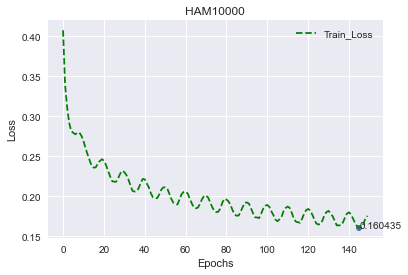

In [18]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

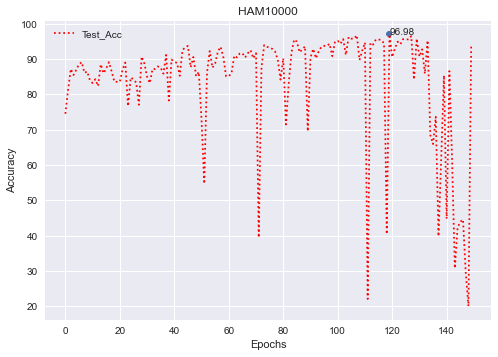

In [19]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [20]:
network.load_state_dict(torch.load(save_PATH))
for i in range(5):
    test()

HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.981%
Best_ACC[96.981%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.981%
Best_ACC[96.981%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.981%
Best_ACC[96.981%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.981%
Best_ACC[96.981%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.981%
Best_ACC[96.981%]


In [21]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    1.0    | 0.826  | 0.905 |          |
|  bcc   |   0.8214  | 0.885  | 0.852 |          |
|  bkl   |   0.8714  | 0.924  | 0.897 |          |
|   df   |   0.4286  |  0.5   | 0.462 |          |
|  mel   |   0.9677  | 0.882  | 0.923 |          |
|   nv   |   0.9925  | 0.994  | 0.993 |          |
|  vasc  |   0.8889  |  0.8   | 0.842 |          |
| Total: |           |        |       |  0.9698  |
+--------+-----------+--------+-------+----------+


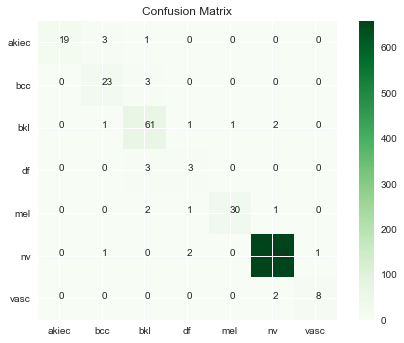

In [22]:
confusion_matrix(evl_result)

In [23]:
# #save
s1 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
s2 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)

In [24]:
torch.cuda.memory.empty_cache()

In [25]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((312,312)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [26]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"skin_lesion"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 168
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 10]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 7 types.
Using 10 dataloader workers every process.
using 51699 images for training, 828 images for validation.


In [27]:
network.load_state_dict(torch.load(save_PATH))
for i in range(5):
    test()

HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:97.343%
Best_ACC[97.343%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:97.343%
Best_ACC[97.343%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:97.343%
Best_ACC[97.343%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:97.343%
Best_ACC[97.343%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:97.343%
Best_ACC[97.343%]


In [28]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    1.0    | 0.826  | 0.905 |          |
|  bcc   |   0.8621  | 0.962  | 0.909 |          |
|  bkl   |   0.8841  | 0.924  | 0.904 |          |
|   df   |   0.4286  |  0.5   | 0.462 |          |
|  mel   |   0.9677  | 0.882  | 0.923 |          |
|   nv   |   0.9925  | 0.995  | 0.994 |          |
|  vasc  |    1.0    |  0.8   | 0.889 |          |
| Total: |           |        |       |  0.9734  |
+--------+-----------+--------+-------+----------+


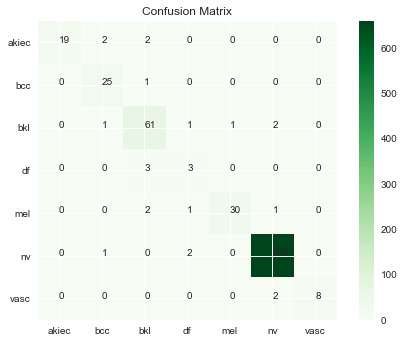

In [29]:
confusion_matrix(evl_result)